<a href="https://colab.research.google.com/github/pranshiii/Handwritten-Digits-Classifier/blob/main/Softmax_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mnist
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
plt.rcParams['figure.dpi'] = 200

In [ ]:
X_train = mnist.train_images()
y_train = mnist.train_labels()
X_test =  mnist.test_images()
y_test = mnist.test_labels()

In [ ]:
X_train.shape

(60000, 28, 28)

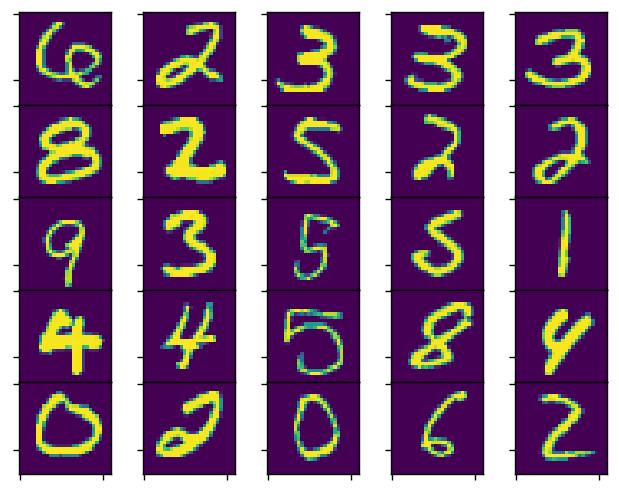

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots(nrows = 5, ncols = 5)

fig.set_dpi(125)
for i in range(5) :
  for j in range(5) :
    r_idx = np.random.randint(X_train.shape[0])
    ax[i][j].imshow(X_train[r_idx])
    ax[i][j].set_xticklabels([])
    ax[i][j].set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# **Vanilla Softmax Classifier**

In [ ]:
class SoftmaxModel :
  
  def __init__(self, alpha=0.001, iters=1000) :
    self.alpha = alpha
    self.iters = iters
    self.cost_list = []
    self.iter_list = []
    self.labels = {}
    self.weights = None
    self.biases = None
    self.descent_type = "Vanilla Model"


  def label_encoder(self, y) : # only accepts numpy array
    '''
    Encodes target labels with value between 0 and k_classes-1. 
    '''
    uniques = np.unique(y)
    for i in range(len(uniques)) :
      self.labels[i] = uniques[i]
      y[y==uniques[i]]=i
    return np.array(y, dtype='int')


  def label_decoder(self, y) : 
    '''
    Decodes numerically encoded targets to original class labels.

    Not to be used as a standalone function.
    '''
    y = np.array(y, dtype='object')
    uniques = np.unique(y)
    for unique in uniques:
      y[y==unique] = self.labels[unique]
    return y
  
  
  def one_hot(self, y) :
    '''
    Converts target labels into one hot matrix, internally uses label_encoder().
    '''
    y_encoded = np.array(self.label_encoder(np.array(y)), dtype='int')
    m_samples = len(y_encoded)
    k_classes = len(np.unique(y_encoded))
    y_hot = np.zeros((m_samples, k_classes))
    y_hot[np.arange(len(y_encoded)), y_encoded] = 1
    return y_hot


  def softmax(self, x) :
    '''
    Returns numerical stable softmax of a matrix, treating each row as an one-hot vector.
    '''
    # Numerically Stable Softmax
    # https://stackoverflow.com/questions/42599498/numercially-stable-softmax
    # x.shape = m x k
    # softmax.shape = m x k
    # Handles overflows
    z = np.exp(x - np.amax(x, axis=1).reshape(-1, 1))
    return z/np.sum(z, axis=1).reshape(-1, 1)


  def sigmoid(self, x):
    return 1/(1+np.exp(-x))


  def categorical_cross_entropy_cost(self, y_predicted, y_hot) :
    return -np.mean(np.multiply(y_hot, np.log(y_predicted)))


  def fit(self, X, y) :
    m_samples, n_features = X.shape
    k_classes = len(np.unique(y))
    y_hot = self.one_hot(y)

    self.weights = np.random.rand(n_features, k_classes)
    self.biases = np.random.rand(k_classes)

    for i in range(self.iters) :
      h_x = np.dot(X, self.weights) + self.biases # XW + b
      y_predicted = self.softmax(h_x) # softmax(XW + b)

      Jw = (1/m_samples) * np.dot(X.T, (y_predicted - y_hot))
      Jb = (1/m_samples) * np.sum(y_predicted - y_hot)

      self.weights = self.weights - self.alpha * Jw
      self.biases = self.biases - self.alpha * Jb

      if(i%(self.iters * 0.01)==0) :
        cost = self.categorical_cross_entropy_cost(y_predicted, y_hot)
        self.cost_list.append(cost)
        self.iter_list.append(i)
        if(i%(self.iters * 0.1)==0):
          print(f'{i} -> {cost}')  
  

  def predict(self, X) :
    h_x = np.dot(X, self.weights) + self.biases
    y_predicted = self.softmax(h_x)
    return np.argmax(y_predicted, axis=1)


  def plot_loss(self) :
    plt.plot(self.iter_list, self.cost_list, label=self.descent_type)
    plt.xlabel("Iterations")
    plt.ylabel("Categorical Cross Entropy")

  def accuracy(self, X, y) :
    y_predicted = self.predict(X)
    y = self.label_encoder(y)
    return np.sum(y==y_predicted)/len(y)

In [ ]:
X_train = X_train.reshape(60000, 28*28)/255
X_test = X_test.reshape(10000, 28*28)/255

In [ ]:
model = SoftmaxModel(alpha = 0.9, iters=1000)
model.fit(X_train, y_train)

0 -> 0.4620087412022805
100 -> 0.04074280890514807
200 -> 0.03587171566039543
300 -> 0.03370950323641925
400 -> 0.03240344539842351
500 -> 0.031496769116461994
600 -> 0.030814906278089093
700 -> 0.030274991523485617
800 -> 0.029831941625683134
900 -> 0.02945878183220675


In [ ]:
print("Train Accuracy -> ", model.accuracy(X_train, y_train) * 100, "%")
print("Test Accuracy -> ", model.accuracy(X_test, y_test) * 100, "%")

Train Accuracy ->  91.91 %
Test Accuracy ->  91.63 %


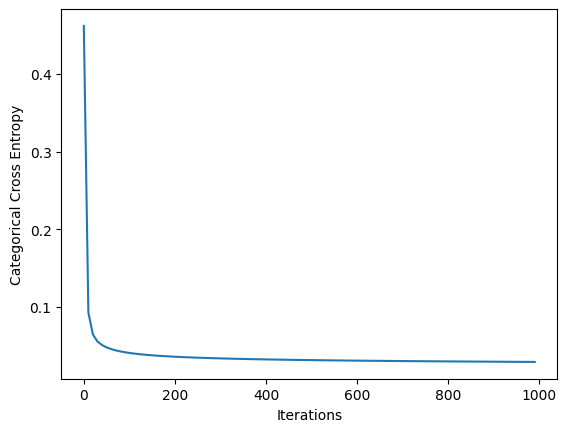

In [ ]:
model.plot_loss()

# **Optimized Softmax Classifier**

⚡ **Optimizations**

1.   Stochastic & Mini-Batch Gradient Descent
2.   Regularization
3.   Momentum



In [ ]:
class SGDSoftmaxModel(SoftmaxModel) :
  
  def __init__(self, alpha=0.001, beta=0.5, gamma=0, iters=1000) :
    super().__init__(alpha, iters)
    self.beta = beta    
    self.gamma = gamma    
    self.batch_size = None
    self.descent_type = "Stochastic Model"

  def fit(self, X, y, batch_size) :
    self.batch_size = batch_size
    m_samples, n_features = X.shape
    k_classes = len(np.unique(y))
    y_hot = self.one_hot(y)
    self.weights = np.random.rand(n_features, k_classes)
    self.biases = np.random.rand(k_classes)
    Vw, Vb = 0, 0

    for i in range(self.iters) :
      
      # Implementing Mini Batch
      r_idx = np.random.randint(m_samples, size=batch_size)
      h_x = np.dot(X[r_idx], self.weights) + self.biases
      y_predicted = self.softmax(h_x)

      # Implementing Momentum and Regularization
      Jw = (1/batch_size) * (np.dot(X[r_idx].T, (y_predicted - y_hot[r_idx])) + self.gamma * self.weights)
      Jb = (1/batch_size) * (np.sum(y_predicted - y_hot[r_idx]) + self.gamma * self.biases)

      Vw = self.beta * Vw + (1-self.beta) * Jw
      Vb = self.beta * Vb + (1-self.beta) * Jb

      self.weights = self.weights - self.alpha * Vw
      self.biases = self.biases - self.alpha * Vb

      if(i%int(self.iters * 0.01)==0) :
        cost = self.categorical_cross_entropy_cost(y_predicted, y_hot[r_idx])
        self.cost_list.append(cost)
        self.iter_list.append(i)
        if(i%int(self.iters * 0.1)==0):
          print(f'{i} -> {cost}')  

In [ ]:
SGDmodel = SGDSoftmaxModel(alpha = 1, beta=0.9, gamma=0.05, iters=1001)
SGDmodel.fit(X_train, y_train, batch_size=1000)

0 -> 0.512550226039916
100 -> 0.032886396985139156
200 -> 0.03539323522241472
300 -> 0.033143320815258885
400 -> 0.03760850365357896
500 -> 0.028582747431148504
600 -> 0.03256863435487476
700 -> 0.0292637497615906
800 -> 0.02851722035507199
900 -> 0.02731158892113449
1000 -> 0.029416457492735987


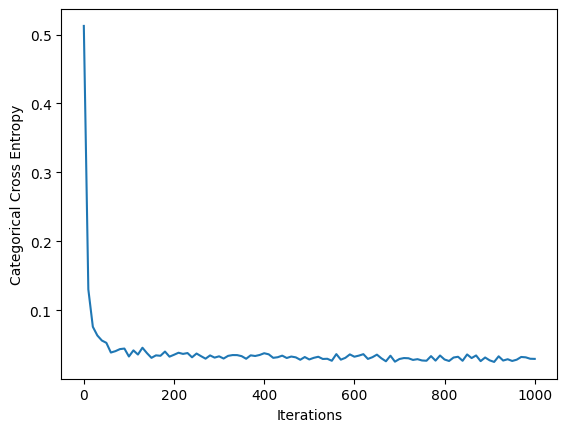

In [ ]:
SGDmodel.plot_loss()

In [ ]:
print("Train Accuracy -> ", SGDmodel.accuracy(X_train, y_train) * 100, "%")
print("Test Accuracy -> ", SGDmodel.accuracy(X_test, y_test) * 100, "%")

Train Accuracy ->  91.93833333333333 %
Test Accuracy ->  91.72 %


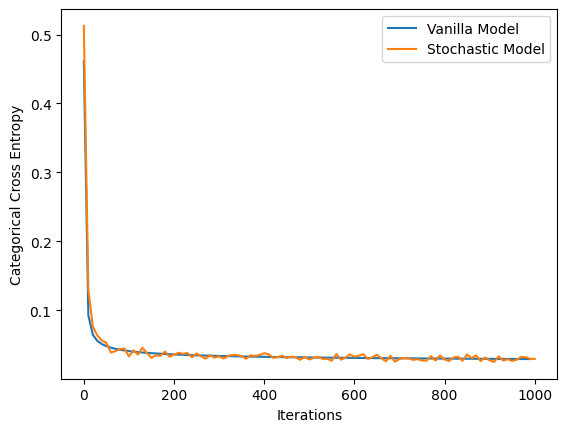

In [ ]:
model.plot_loss()
SGDmodel.plot_loss()
plt.legend()
plt.show()

# **Performance Metrics**



## 1. Classification Report

In [ ]:
predictions_vanilla = model.predict(X_test)
predictions_stochastic = SGDmodel.predict(X_test)
print("Classification Report for Vanilla Model.\n")
print(classification_report(y_test, predictions_vanilla))
print("\n\nClassification Report for Stochastic Model.\n")
print(classification_report(y_test, predictions_stochastic))

Classification Report for Vanilla Model.

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.90      0.90      0.90      1010
           4       0.92      0.92      0.92       982
           5       0.89      0.85      0.87       892
           6       0.93      0.94      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.85      0.88      0.87       974
           9       0.90      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Classification Report for Stochastic Model.

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.98      0.97

## 2. Confusion Matrix

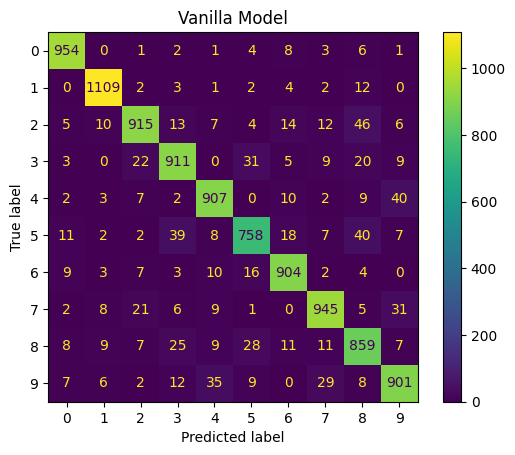

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions_vanilla))
disp.plot()
plt.title("Vanilla Model")
plt.show()

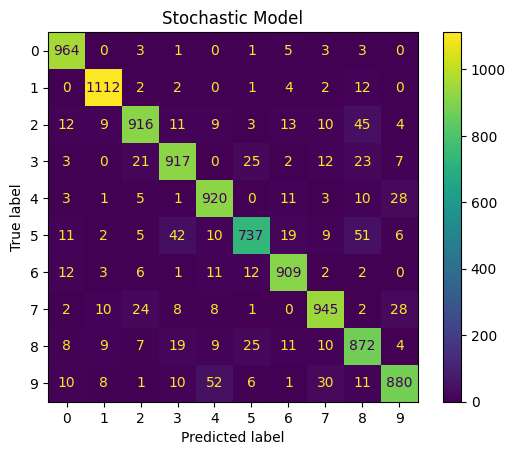

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions_stochastic))
disp.plot()
plt.title("Stochastic Model")
plt.show()